# Many to One Classification

Simple example for Many to one (word sentiment classification) by Recurrent Neural Networks


- Creating the **data pipeline** with `tf.data`
- Preprocessing word sequences (variable input sequence length) using `padding technique` by `user function (pad_seq)`
- Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
- Creating the model as **Class**
- Reference
    - https://github.com/golbin/TensorFlow-Tutorials/blob/master/10%20-%20RNN/02%20-%20Autocomplete.py
    - https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Sequence%20classification%20with%20RNN%20series.ipynb


### Setup

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
%matplotlib inline
slim = tf.contrib.slim

print(tf.__version__)

Instructions for updating:
Use the retry module or similar alternatives.
1.7.0


### Prepare example data

In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space

'abcdefghijklmnopqrstuvwxyz *'

In [4]:
char_dic = {char : idx for idx, char in enumerate(char_space)}
print(char_dic)

{'f': 5, 'z': 25, 'k': 10, 'y': 24, 'j': 9, 's': 18, ' ': 26, 'l': 11, 't': 19, 'r': 17, 'b': 1, 'p': 15, 'h': 7, 'd': 3, 'w': 22, 'c': 2, '*': 27, 'm': 12, 'i': 8, 'v': 21, 'e': 4, 'u': 20, 'o': 14, 'g': 6, 'n': 13, 'x': 23, 'a': 0, 'q': 16}


### Create pad_seq function

In [5]:
def pad_seq(sequences, max_len, dic):
    seq_len, seq_indices = [], []
    for seq in sequences:
        seq_len.append(len(seq))
        seq_idx = [dic.get(char) for char in seq]
        seq_idx += (max_len - len(seq_idx)) * [dic.get('*')] # 27 is idx of meaningless token "*"
        seq_indices.append(seq_idx)
    return seq_len, seq_indices

### Apply pad_seq function to data

In [6]:
max_length = 10
X_length, X_indices = pad_seq(sequences = words, max_len = max_length, dic = char_dic)

In [7]:
print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


In [8]:
X_indices

[[6, 14, 14, 3, 27, 27, 27, 27, 27, 27],
 [1, 0, 3, 27, 27, 27, 27, 27, 27, 27],
 [0, 12, 0, 25, 8, 13, 6, 27, 27, 27],
 [18, 14, 26, 6, 14, 14, 3, 27, 27, 27],
 [1, 20, 11, 11, 26, 18, 7, 8, 19, 27],
 [0, 22, 4, 18, 14, 12, 4, 27, 27, 27]]

### Define CharRNN class

In [9]:
class CharRNN:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):

        with tf.variable_scope('input_layer'):
            # input layer를 구현해보세요
            # tf.get_variable을 사용하세요
            # tf.nn.embedding_lookup을 사용하세요
            
            # 여기는 data pipeline
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype = tf.float32)
            one_hot_weights = tf.get_variable(name='one_hot_embedding',initializer=one_hot,
                                            trainable=False)
            self.X_batch = tf.nn.embedding_lookup(params=one_hot_weights, ids=self._X_indices)
            #  self.X_batch = tf.one_hot(self._X_indices, len(dic))

        # RNN cell
        with tf.variable_scope('rnn_cell'):
            # RNN cell을 구현해보세요
            # tf.contrib.rnn.BasicRNNCell을 사용하세요
            # tf.nn.dynamic_rnn을 사용하세요
            rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_dim,
                                                  activation=tf.nn.tanh)
            # output:[batch_size,max_len, cell_size]
            # state:[batch_size, cell_size]
            self.outputs, self.state = tf.nn.dynamic_rnn(cell=rnn_cell, 
                                                         inputs=self.X_batch, 
                                                         sequence_length=self._X_length,
                                                         dtype=tf.float32)
            
        with tf.variable_scope('output_layer'):
            # slim.fully_connected를 사용하세요
            # [batch_size x n_of_classes]
            self.score = slim.fully_connected(inputs=self.state, num_outputs=n_of_classes, activation_fn=None)

        with tf.variable_scope('loss'):
            # tf.losses.softmax_cross_entropy를 사용하세요
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self.score)
            
            
        with tf.variable_scope('prediction'):
            # tf.argmax를 사용하세요
            self.pred = tf.argmax(input=self.score, axis=1, output_type=tf.int32)
        
    def predict(self, sess, X_length, X_indices):
        # predict instance method를 구현해보세요
        feed_prediction={self._X_length:X_length, self._X_indices:X_indices}
        return sess.run(self.pred, feed_dict=feed_prediction)

### Create a model of CharRNN

In [10]:
# hyper-parameter#
lr = .003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [11]:
## create data pipeline with tf.data
# tf.data를 이용해서 직접 구현해보세요
train_data = tf.data.Dataset.from_tensor_slices((X_length, X_indices,y))

In [12]:
train_data = train_data.shuffle(buffer_size=10)
train_data = train_data.batch(batch_size=batch_size)
tr_iterator = train_data.make_initializable_iterator()

In [13]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [14]:
# 최종적으로 model은 아래의 코드를 통해서 생성됩니다.
char_rnn = CharRNN(X_length = X_length_mb, X_indices = X_indices_mb, y = y_mb, n_of_classes = 2,
                   hidden_dim = 16, dic = char_dic)

In [15]:
char_rnn.outputs

<tf.Tensor 'rnn_cell/rnn/transpose_1:0' shape=(?, 10, 16) dtype=float32>

In [16]:
char_rnn.state

<tf.Tensor 'rnn_cell/rnn/while/Exit_3:0' shape=(?, 16) dtype=float32>

### Creat training op and train model

In [17]:
## create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)
training_op = opt.minimize(loss = char_rnn.ce_loss)

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    sess.run(tr_iterator.initializer)
    try:
        while True:
            # 여기를 직접구현하시면 됩니다.
            _, loss = sess.run([training_op, char_rnn.ce_loss])
            avg_tr_loss += loss
            tr_step += 1
    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   1, tr_loss : 0.667
epoch :   2, tr_loss : 0.581
epoch :   3, tr_loss : 0.502
epoch :   4, tr_loss : 0.436
epoch :   5, tr_loss : 0.372
epoch :   6, tr_loss : 0.306
epoch :   7, tr_loss : 0.251
epoch :   8, tr_loss : 0.201
epoch :   9, tr_loss : 0.160
epoch :  10, tr_loss : 0.126


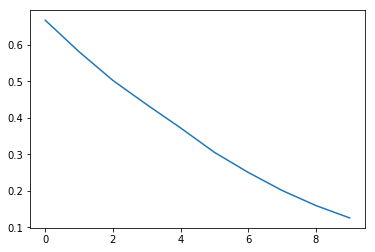

In [19]:
plt.plot(tr_loss_hist, label = 'train')

In [20]:
yhat = char_rnn.predict(sess = sess, X_length = X_length, X_indices = X_indices)

In [21]:
print('training acc: {:.2%}'.format(np.mean(yhat == np.argmax(y, axis = -1))))

training acc: 100.00%
